In [1]:
import os
from pathlib import Path
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append('./SuperGluePretrainedNetwork')

from models.matching import Matching

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(42)
random.seed(42)

# Charuco board parameters (for world coordinates plot)
DICT_TYPE = cv2.aruco.DICT_5X5_100

aruco_dict = cv2.aruco.getPredefinedDictionary(DICT_TYPE)
detector = cv2.aruco.ArucoDetector(aruco_dict)

board = cv2.aruco.CharucoBoard((13, 9), 0.02, 0.01, aruco_dict)

squares_x, squares_y = board.getChessboardSize()
square_length = board.getSquareLength()

# Load SuperPoint, SuperGlue model
with torch.no_grad():
    matching = Matching({
        'superpoint': {'nms_radius': 4, 'keypoint_threshold': 0.005, 'max_keypoints': 1024},
        'superglue': {'weights': 'indoor'},
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2,
    }).eval().to(device)

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)


### Feature matching between 2 images

In [2]:
def feature_match_between_images(img1, img2):
    """Feature matching using SUPERGLUE."""
    
    # Convert to tensor (SUPERGLUE input format)
    img1 = cv2.resize(img1, (1024, 1024))
    img2 = cv2.resize(img2, (1024, 1024))
    tensor1 = torch.from_numpy(img1 / 255.).float()[None, None].to(device)
    tensor2 = torch.from_numpy(img2 / 255.).float()[None, None].to(device)

    # Perform SUPERGLUE matching
    inp = {'image0': tensor1, 'image1': tensor2}
    pred = matching(inp)
    
    # Extract results
    kpts1 = pred['keypoints0'][0].cpu().numpy()
    kpts2 = pred['keypoints1'][0].cpu().numpy()
    matches = pred['matches0'][0].cpu().numpy()
    
    # Filter only valid matches
    valid = matches > -1
    matched_kpts1 = kpts1[valid]
    matched_kpts2 = kpts2[matches[valid]]

    good_matches = []
    matched_ids = []
    
    for i, (pt1, pt2) in enumerate(zip(matched_kpts1, matched_kpts2)):
        pt1_tuple = tuple(pt1.astype(float))
        pt2_tuple = tuple(pt2.astype(float))
        good_matches.append((pt1_tuple, pt2_tuple))
        matched_ids.append(i)
    
    num_kpts1 = len(kpts1)
    num_kpts2 = len(kpts2)
    
    return good_matches, matched_ids, (num_kpts1, num_kpts2)

In [3]:
IMAGE_DIR = Path('./camera_images')
filenames = sorted(os.listdir(IMAGE_DIR), key=lambda x: int(x.split('.')[0]))

img1 = cv2.imread(str(IMAGE_DIR / filenames[0]), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(str(IMAGE_DIR / filenames[1]), cv2.IMREAD_GRAYSCALE)

matches, matched_ids, num_features = feature_match_between_images(img1, img2)

print("===Feature detect and match result===")
print(f"image1: {num_features[0]} features, image2: {num_features[1]} features. {len(matches)} matches")

===Feature detect and match result===
image1: 918 features, image2: 980 features. 855 matches


### Homography estimation (with and w/o RANSAC)
We compared the performance (reprojection error) with and without RANSAC algorithm.

In [4]:
def compute_homography(matches):
    A = []
    for (x, y), (xp, yp) in matches:
        A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])
    A = np.array(A)

    # SVD
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    H = h.reshape(3, 3)
    return H / H[2, 2]

def average_reprojection_error(matches, H):
    total_error = 0
    for (x, y), (xp, yp) in matches:
        p = np.array([x, y, 1.0])
        projected = H @ p
        projected /= projected[2]
        error = np.linalg.norm(projected[:2] - np.array([xp, yp]))
        total_error += error
    return total_error / len(matches)

def ransac_homography(matches, threshold=3.0, iterations=1000):
    best_H = None
    max_inliers = 0
    best_inliers = []

    for _ in range(iterations):
        sample = random.sample(matches, 4)
        H_candidate = compute_homography(sample)
        inliers = []

        for (x, y), (xp, yp) in matches:
            p = np.array([x, y, 1.0])
            projected = H_candidate @ p
            projected /= projected[2]
            error = np.linalg.norm(projected[:2] - np.array([xp, yp]))
            if error < threshold:
                inliers.append(((x, y), (xp, yp)))

        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_H = H_candidate
            best_inliers = inliers

    return best_H / best_H[2,2], best_inliers

matches, matched_ids, num_features = feature_match_between_images(img1, img2)

H = compute_homography(matches)
error = average_reprojection_error(matches, H)
print(f"Average Reprojection Error: {error:.4f} pixels")

H_ransac, inlier_matches = ransac_homography(matches, threshold=5.0, iterations=1000)
print(H_ransac)
error = average_reprojection_error(inlier_matches, H_ransac)

print(f"RANSAC Homography Inliers: {len(inlier_matches)} / {len(matches)}")
print(f"Average Reprojection Error after RANSAC: {error:.4f} pixels")

Average Reprojection Error: 1.1754 pixels
[[ 1.17247042e+00  1.31297411e-02  7.00258630e+00]
 [ 4.43414785e-02  1.10958284e+00 -2.43249136e+01]
 [ 1.38505713e-04 -3.12223967e-06  1.00000000e+00]]
RANSAC Homography Inliers: 850 / 855
Average Reprojection Error after RANSAC: 1.3125 pixels


### Feature matching with reference image

Reference image's feature matching with ChArUco board should be done in advance. This is required for plotting the **calibration board** and cameras in **world coordinates**.

In [6]:
# reference image: first image in the list
ref_img = cv2.imread(IMAGE_DIR / filenames[0], cv2.IMREAD_GRAYSCALE)
ref_img = cv2.resize(ref_img, (1024, 1024))

_corners, _ids, _ = cv2.aruco.detectMarkers(ref_img, aruco_dict)
_, corners, ids = cv2.aruco.interpolateCornersCharuco(
        _corners, _ids, ref_img, board)

ref_charuco_image_pts = corners.reshape(-1, 2)
ref_charuco_ids = ids.flatten()

# Convert matched points in reference image to world coordinates
ref_charuco_world_pts = []
for corner_id in ref_charuco_ids:
    row = corner_id // (squares_x - 1)
    col = corner_id % (squares_x - 1)
    world_x = col * square_length
    world_y = row * square_length
    ref_charuco_world_pts.append([world_x, world_y])

ref_charuco_world_pts = np.array(ref_charuco_world_pts, dtype=np.float32)

matches = []
for i in range(len(ref_charuco_image_pts)):
    image_pt = tuple(ref_charuco_image_pts[i].astype(float))
    world_pt = tuple(ref_charuco_world_pts[i].astype(float))
    matches.append((image_pt, world_pt))

# Compute reference image's homography to world coordinates
H_ref_to_world = compute_homography(matches)

In [ ]:
def feature_match_with_reference_image(img):
    ref_tensor = torch.from_numpy(ref_img / 255.).float()[None, None].to(device)
    img_tensor = torch.from_numpy(img / 255.).float()[None, None].to(device)
    
    # Perform SUPERGLUE matching
    inp = {'image0': ref_tensor, 'image1': img_tensor}
    pred = matching(inp)
    
    # Extract results
    kpts_ref = pred['keypoints0'][0].cpu().numpy()
    kpts_img = pred['keypoints1'][0].cpu().numpy()
    matches = pred['matches0'][0].cpu().numpy()
    
    # Filter only valid matches
    valid = (matches > -1)
    matched_ref_kpts = kpts_ref[valid]
    matched_img_kpts = kpts_img[matches[valid]]
    
    # Convert matched points to world coordinates
    good_matches = []
    matched_ids = []
            
    for i, (ref_pt, img_pt) in enumerate(zip(matched_ref_kpts, matched_img_kpts)):
        ref_pt_homo = np.array([ref_pt[0], ref_pt[1], 1.0])
        world_pt_homo = H_ref_to_world @ ref_pt_homo
        
        if abs(world_pt_homo[2]) < 1e-8:
            continue
            
        world_x = world_pt_homo[0] / world_pt_homo[2]
        world_y = world_pt_homo[1] / world_pt_homo[2]
        
        img_u = float(img_pt[0])
        img_v = float(img_pt[1])
        
        good_matches.append(((world_x, world_y), (img_u, img_v)))
        matched_ids.append(i)
    
    num_features = len(good_matches)
    
    return good_matches, matched_ids, num_features

img2 = cv2.resize(img2, (1024, 1024))
matches, matched_ids, num_features = feature_match_with_reference_image(img2)
print("===SUPERGLUE detect and match result===")
print(f"image2: {num_features} features. {len(matches)} matches with the reference image")

===SUPERGLUE detect and match result===
image2: 855 features. 855 matches with the reference image


### Main Pipeline
1. Feature Matching with ref. image (converted to world coordinates, through ref. image)
2. Homography Estimation (with **RANSAC**)
3. Compuatation of camera parameters: intrinsics, extrinsics

In [8]:
H_list = []

img0 = cv2.imread(str(IMAGE_DIR / filenames[0]), cv2.IMREAD_GRAYSCALE)
img0 = cv2.resize(img0, (1024, 1024))

for i in range(0, len(filenames)):
    img_path =str(IMAGE_DIR / filenames[i])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (1024, 1024))
    
    matches, _, _ = feature_match_with_reference_image(img)

    H_ransac, inlier_matches = ransac_homography(matches, threshold=5.0, iterations=1000)
    print(H_ransac)
    error = average_reprojection_error(inlier_matches, H_ransac)

    H_list.append(H_ransac)

    print(f"=== Image {i} ===")
    print(f"Matches: {len(matches)}, Inliers: {len(inlier_matches)} / {len(matches)}")
    print(f"Average Reprojection Error: {error:.4f} pixels\n")

[[-2.83175962e+03 -1.47143155e+02  8.17460730e+02]
 [-4.20615120e+00 -2.89464224e+03  6.89330880e+02]
 [-9.08167631e-02 -2.25022541e-01  1.00000000e+00]]
=== Image 0 ===
Matches: 918, Inliers: 918 / 918
Average Reprojection Error: 0.0000 pixels

[[-2.98383344e+03 -1.86524243e+02  8.76044686e+02]
 [-1.14594035e+02 -2.89484318e+03  6.99410195e+02]
 [-4.32270202e-01 -2.10476695e-01  1.00000000e+00]]
=== Image 1 ===
Matches: 855, Inliers: 850 / 855
Average Reprojection Error: 1.0734 pixels

[[-2.76702634e+03 -9.59762147e+01  8.88848600e+02]
 [-4.55586474e+02 -2.55486742e+03  6.55834400e+02]
 [-1.12998262e+00 -1.33212084e-01  1.00000000e+00]]
=== Image 2 ===
Matches: 655, Inliers: 536 / 655
Average Reprojection Error: 1.9027 pixels

[[-2.48807174e+03 -1.83728910e+02  7.65420308e+02]
 [ 4.57178296e+02 -3.23249764e+03  7.16463595e+02]
 [ 9.10706925e-01 -2.98146732e-01  1.00000000e+00]]
=== Image 3 ===
Matches: 842, Inliers: 794 / 842
Average Reprojection Error: 1.3508 pixels

[[-2.00906361e+0

In [9]:
def compute_v_ij(H, i, j):
    return np.array([
        H[0, i]*H[0, j],
        H[0, i]*H[1, j] + H[1, i]*H[0, j],
        H[1, i]*H[1, j],
        H[2, i]*H[0, j] + H[0, i]*H[2, j],
        H[2, i]*H[1, j] + H[1, i]*H[2, j],
        H[2, i]*H[2, j]
    ])

def estimate_intrinsics(H_list):
    
    V = []
    for H in H_list:
        v12 = compute_v_ij(H, 0, 1)
        v11 = compute_v_ij(H, 0, 0)
        v22 = compute_v_ij(H, 1, 1)
        V.append(v12)
        V.append(v11 - v22)
    V = np.array(V)

    # Solve Vb = 0 using SVD
    _, _, Vt = np.linalg.svd(V)
    b = Vt[-1, :]

    # Extract parameters from b
    B11, B12, B22, B13, B23, B33 = b
    v0 = (B12*B13 - B11*B23) / (B11*B22 - B12**2)
    lam = B33 - (B13**2 + v0*(B12*B13 - B11*B23)) / B11
    alpha = np.sqrt(lam / B11)
    beta = np.sqrt(lam * B11 / (B11*B22 - B12**2))
    gamma = -B12 * alpha**2 * beta / lam
    u0 = gamma * v0 / beta - B13 * alpha**2 / lam


    # Construct K matrix
    K = np.array([
        [alpha, gamma, u0],
        [0,     beta,  v0],
        [0,     0,     1]
    ])

    return K

def estimate_extrinsics(H, K):
    K_inv = np.linalg.inv(K)
    h1 = H[:, 0]
    h2 = H[:, 1]
    h3 = H[:, 2]

    lambda_ = 1.0 / np.linalg.norm(K_inv @ h1)
    r1 = lambda_ * (K_inv @ h1)
    r2 = lambda_ * (K_inv @ h2)
    r3 = np.cross(r1, r2)
    t = lambda_ * (K_inv @ h3)

    # Ensure R is a valid rotation matrix using orthonormalization (SVD)
    R = np.stack([r1, r2, r3], axis=1)
    U, _, Vt = np.linalg.svd(R)
    R_orthonormal = U @ Vt

    return R_orthonormal, t

K = estimate_intrinsics(H_list)
print("Estimated Intrinsic Matrix K:\n\n", K)

extrinsics = []

# Append the extrinsics for the other cameras
for idx, H in enumerate(H_list):
    R, t = estimate_extrinsics(H, K)
    print(f"=== Image {idx} ===")
    print("Rotation Matrix R:\n", R)
    print("Translation Vector t:\n", t)
    print()
    extrinsics.append((R, t))

Estimated Intrinsic Matrix K:

 [[ 1.00947661e+03 -3.15260635e+00  4.89835517e+02]
 [ 0.00000000e+00  1.00954808e+03  5.16208870e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
=== Image 0 ===
Rotation Matrix R:
 [[-0.99931695 -0.01446806 -0.03400451]
 [ 0.01718078 -0.99657516 -0.0808874 ]
 [-0.03271777 -0.08141637  0.99614302]]
Translation Vector t:
 [0.1176654  0.06206931 0.36195256]

=== Image 1 ===
Rotation Matrix R:
 [[-0.98701167 -0.03007627 -0.15780807]
 [ 0.04154727 -0.99668834 -0.06990119]
 [-0.15518309 -0.07554978  0.98499261]]
Translation Vector t:
 [0.13774307 0.06523823 0.35950139]

=== Image 2 ===
Rotation Matrix R:
 [[-0.8878617  -0.02110533 -0.45962612]
 [ 0.04488713 -0.99815549 -0.04087488]
 [-0.45791566 -0.05692253  0.88717139]]
Translation Vector t:
 [0.16022383 0.05600151 0.40491317]

=== Image 3 ===
Rotation Matrix R:
 [[-0.95436653 -0.02019674  0.29795404]
 [-0.00935374 -0.9951994  -0.09742   ]
 [ 0.29849125 -0.09576137  0.94959609]]
Translation Vector t:

### Visualize the result

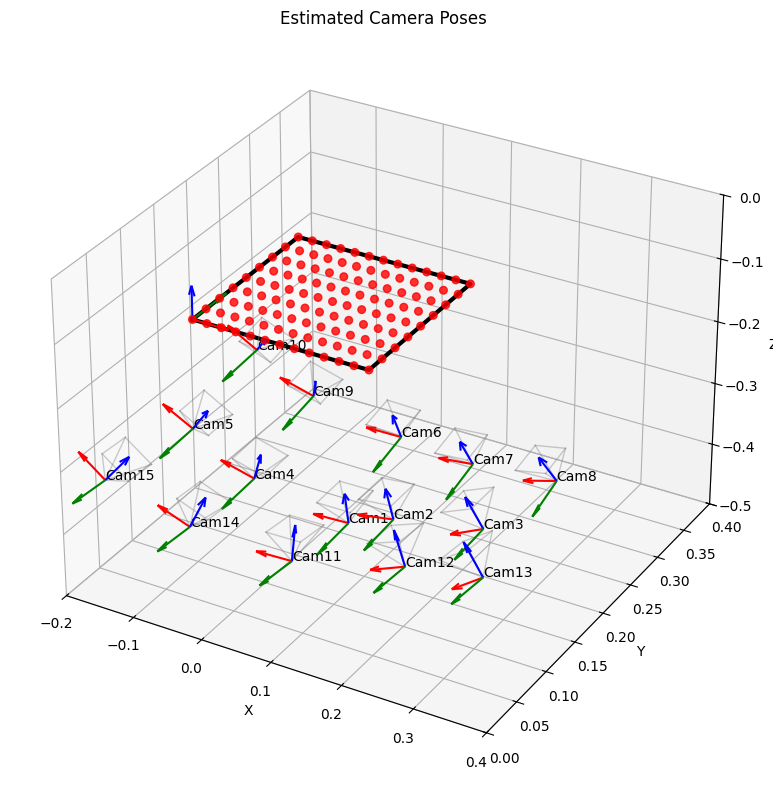

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def plot_camera_frustum(ax, R, camera_center, scale):
    """
    Visualize the camera frustum (field of view).
    """
    l, w, h = scale * 1.5, scale * 0.8, scale * 0.6
    
    # Frustum corner points in camera coordinates
    frustum_points_local = np.array([
        [0, 0, 0],  # Camera center
        [-w, -h, l],
        [ w, -h, l],
        [ w,  h, l],
        [-w,  h, l]
    ])
    
    # Transform to world coordinates
    frustum_points_world = []
    for point in frustum_points_local:
        world_point = R @ point + camera_center
        frustum_points_world.append(world_point)
    
    frustum_points_world = np.array(frustum_points_world)
    
    # Draw lines from camera center to each corner and between corners
    for i in range(1, 5):
        ax.plot(
            [frustum_points_world[0, 0], frustum_points_world[i, 0]],
            [frustum_points_world[0, 1], frustum_points_world[i, 1]],
            [frustum_points_world[0, 2], frustum_points_world[i, 2]], 
            color='gray', alpha=0.4, linewidth=1
        )
        next_i = i + 1 if i < 4 else 1
        ax.plot(
            [frustum_points_world[i, 0], frustum_points_world[next_i, 0]],
            [frustum_points_world[i, 1], frustum_points_world[next_i, 1]],
            [frustum_points_world[i, 2], frustum_points_world[next_i, 2]], 
             color='gray', alpha=0.4, linewidth=1
        )
    
def plot_camera_poses(extrinsics):
    """
    Visualize camera extrinsics and ChArUco board in 3D space.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Draw ChArUco board corners
    squares_x, squares_y = 13, 9
    square_length = 0.02

    x_coords, y_coords = np.meshgrid(
        np.arange(squares_x) * square_length,
        np.arange(squares_y) * square_length
    )
    z_coords = np.zeros_like(x_coords.flatten())
    
    ax.scatter(x_coords.flatten(), y_coords.flatten(), z_coords, c='red', s=30, alpha=0.8)
    
    # Draw board boundary
    max_x = (squares_x - 1) * square_length
    max_y = (squares_y - 1) * square_length
    boundary_x = [0, max_x, max_x, 0, 0]
    boundary_y = [0, 0, max_y, max_y, 0]
    boundary_z = [0, 0, 0, 0, 0]
    ax.plot(boundary_x, boundary_y, boundary_z, 'k-', linewidth=3)

    # Draw world coordinate axes
    ax.quiver(0, 0, 0, 0.1, 0, 0, color='r', length=0.5)
    ax.quiver(0, 0, 0, 0, 0.1, 0, color='g', length=0.5)
    ax.quiver(0, 0, 0, 0, 0, 0.1, color='b', length=0.5)

    for idx, (R, t) in enumerate(extrinsics):
        # Camera center in world coordinates
        C = -R.T @ t

        # Draw camera axes
        cam_axis = R.T
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 0], cam_axis[1, 0], cam_axis[2, 0], color='r', length=0.05)
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 1], cam_axis[1, 1], cam_axis[2, 1], color='g', length=0.05)
        ax.quiver(C[0], C[1], C[2], cam_axis[0, 2], cam_axis[1, 2], cam_axis[2, 2], color='b', length=0.05)

        ax.text(C[0], C[1], C[2], f"Cam{idx+1}", color='black')

        plot_camera_frustum(ax, R, C, scale=0.03)

    # Set axis limits (centered on chessboard)
    ax.set_xlim(-0.2, 0.4)
    ax.set_ylim(0.0, 0.4)
    ax.set_zlim(-0.5, 0.0)

    ax.set_title("Estimated Camera Poses")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=30, azim=-60)
    plt.tight_layout()
    plt.show()

plot_camera_poses(extrinsics)